In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
import numpy as np
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

/Users/mwitebsky/anaconda2/envs/lesson01/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
df = pd.read_csv('../Assets/train.txt', '\t', na_values={'is_news' : '?', 'alchemy_category_score' : '?',
                                                         'news_front_page' : '?'}).fillna(0)

In [8]:
# Extract the title and body from the boilerplate JSON text
df['title'] = df.boilerplate.map(lambda x: json.loads(x).get('title', ''))
df['body'] = df.boilerplate.map(lambda x: json.loads(x).get('body', ''))
df['alchemy_category'] = df['alchemy_category'].apply(lambda x: 'unknown' if x == '?' else x)
df.drop('framebased', axis=1, inplace=True)

In [9]:
data = pd.get_dummies(df, columns= ['alchemy_category'])

In [21]:
data.dtypes

url                                     object
urlid                                    int64
boilerplate                             object
alchemy_category_score                 float64
avglinksize                            float64
commonlinkratio_1                      float64
commonlinkratio_2                      float64
commonlinkratio_3                      float64
commonlinkratio_4                      float64
compression_ratio                      float64
embed_ratio                            float64
frameTagRatio                          float64
hasDomainLink                            int64
html_ratio                             float64
image_ratio                            float64
is_news                                float64
lengthyLinkDomain                        int64
linkwordscore                            int64
news_front_page                        float64
non_markup_alphanum_characters           int64
numberOfLinks                            int64
numwords_in_u

In [35]:
a = data.corr()['label'].sort_values()
columns = list(a.index)
good_columns = columns[0:5] + columns[-8:-1]
good_columns



['frameTagRatio',
 'linkwordscore',
 'alchemy_category_sports',
 'alchemy_category_computer_internet',
 'alchemy_category_arts_entertainment',
 'commonlinkratio_4',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'non_markup_alphanum_characters',
 'commonlinkratio_3',
 'alchemy_category_business',
 'alchemy_category_recreation']

In [49]:
good_predictors = data[good_columns]

In [50]:
# pull features
features_df = good_predictors
# pull target and view split
target_df = data['label']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.33, random_state=5)

In [57]:
logit = LogisticRegression()

x = features_df
y = target_df

logit.fit(x_train, y_train)
logit.score(x_test, y_test)

0.65628840639082342

In [58]:
y_pred = logit.predict(x)

In [59]:
conmat = np.array(confusion_matrix(y, y_pred))

confusion = pd.DataFrame(conmat, index=['is_healthy', 'has_cancer'],
                         columns=['predicted_healthy', 'predicted_cancer'])
confusion

,predicted_healthy,predicted_cancer
is_healthy,2141,1458
has_cancer,1112,2684


In [60]:
from sklearn.metrics import classification_report


In [61]:
cls_rep = classification_report(y, y_pred)
print(cls_rep)

             precision    recall  f1-score   support

          0       0.66      0.59      0.62      3599
          1       0.65      0.71      0.68      3796

avg / total       0.65      0.65      0.65      7395



In [63]:
# Get the predicted probability vector
y_pp = pd.DataFrame(logit.predict_proba(x_test), columns=['prob_no_cancer','prob_cancer'])
print(y_pp.iloc[0:10])

   prob_no_cancer  prob_cancer
0        0.870254     0.129746
1        0.662704     0.337296
2        0.336420     0.663580
3        0.362152     0.637848
4        0.544059     0.455941
5        0.490135     0.509865
6        0.731525     0.268475
7        0.320355     0.679645
8        0.597507     0.402493
9        0.380146     0.619854


(array([ 0.        ,  0.        ,  0.00168776, ...,  0.99831224,
        0.99831224,  1.        ]), array([  7.96178344e-04,   7.96178344e-03,   7.96178344e-03, ...,
         9.99203822e-01,   1.00000000e+00,   1.00000000e+00]), array([ 2.55237825,  1.73598461,  1.71817747, ..., -2.62845464,
       -2.69278638, -3.48983903]))


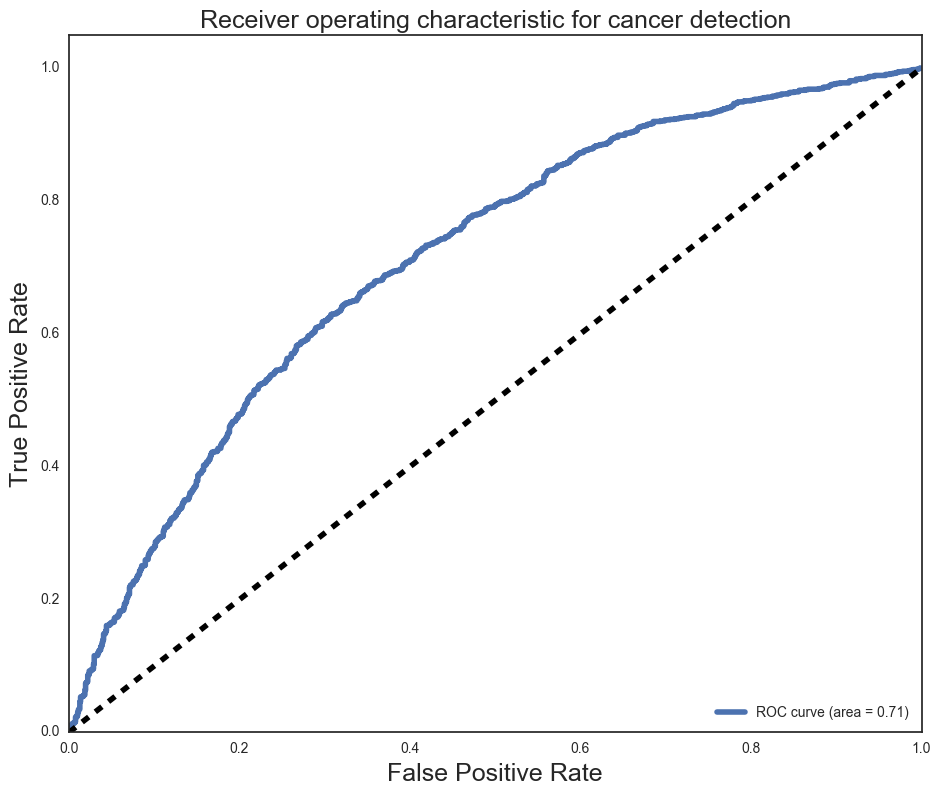

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


y_score = logit.decision_function(x_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

print roc_curve(y_test, y_score)

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()